In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from typing import Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('tweets.csv')
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515


# Exploratory Analysis

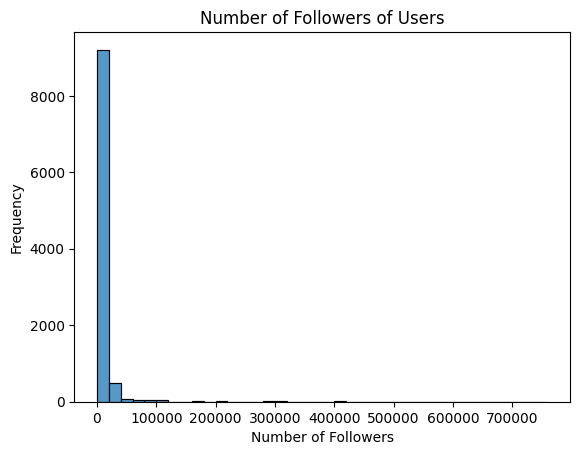

In [3]:
sns.histplot(df['user_followers_count'], binwidth=20000)
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.title('Number of Followers of Users')
plt.show()

In [4]:
def group_followers(num_followers: int) -> str:
    if 0 <= num_followers <= 1000:
        return 'Few'
    elif 1000 < num_followers <= 10000:
        return 'Medium'
    else:
        return 'Many'

In [5]:
df['followers_group'] = df['user_followers_count'].apply(group_followers)

In [6]:
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,followers_group
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145,Medium
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630,Medium
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234,Many
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901,Medium
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515,Few


In [7]:
df['followers_group'].value_counts()

Medium    4371
Few       4216
Many      1413
Name: followers_group, dtype: int64

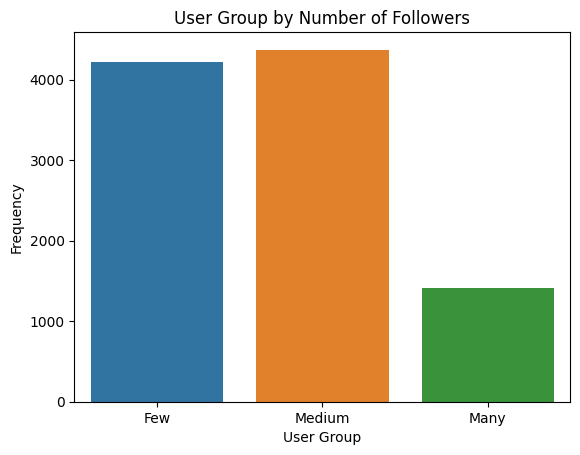

In [44]:
sns.countplot(x=df['followers_group'], order=['Few', 'Medium', 'Many'])
plt.xlabel('User Group')
plt.ylabel('Frequency')
plt.title('User Group by Number of Followers')
plt.show()

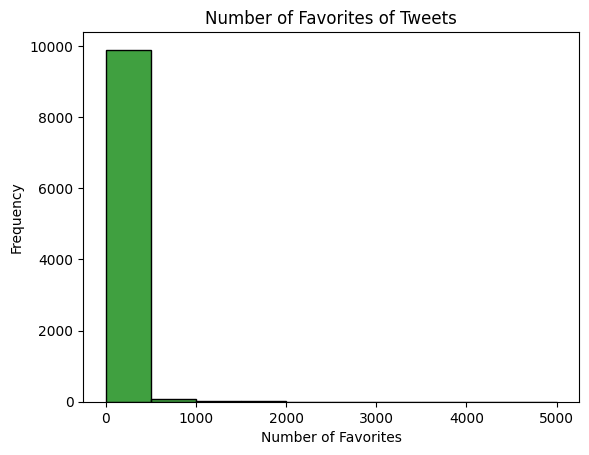

In [49]:
sns.histplot(df['tweet_favourite_count'], binwidth=500, color='green')
plt.xlabel('Number of Favorites')
plt.ylabel('Frequency')
plt.title('Number of Favorites of Tweets')
plt.show()

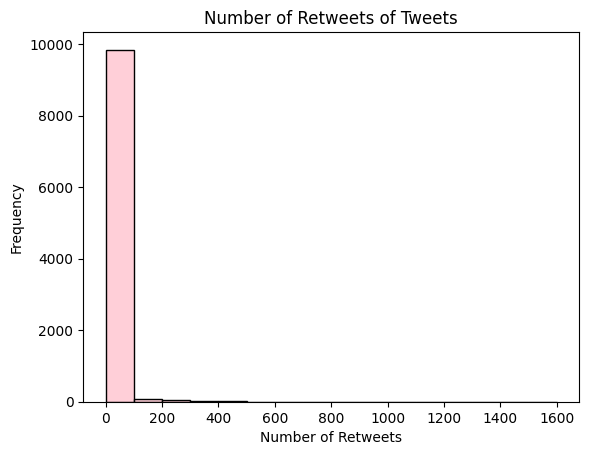

In [50]:
sns.histplot(df['tweet_retweet_count'], binwidth=100, color='pink')
plt.xlabel('Number of Retweets')
plt.ylabel('Frequency')
plt.title('Number of Retweets of Tweets')
plt.show()

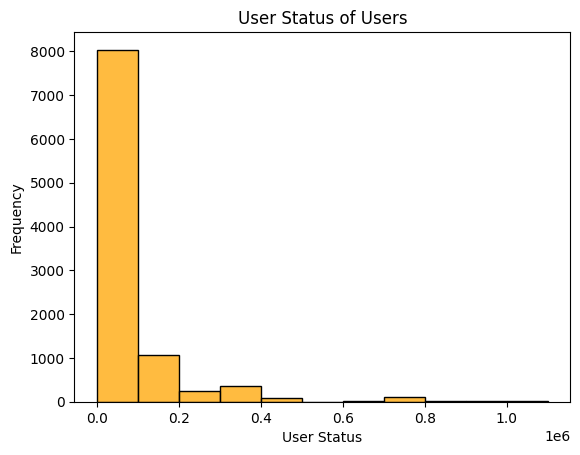

In [53]:
sns.histplot(df['user_statuses_count'], binwidth=100000, color='orange')
plt.xlabel('User Status')
plt.ylabel('Frequency')
plt.title('User Status of Users')
plt.show()

In [8]:
df['user_followers_count'].describe()

count     10000.000000
mean       7752.489200
std       27802.220361
min           0.000000
25%         461.250000
50%        1348.000000
75%        4521.000000
max      755203.000000
Name: user_followers_count, dtype: float64

# Preprocessing

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.add_pipe('sentencizer')

In [14]:
def remove_end_link(tweet: str) -> str:
    return tweet[:tweet.find('https://t.co/')]

def remove_whitespaces(tweet: str) -> str:
    return re.sub(r'\s{1,}', ' ', tweet).strip()

def tokenize_and_lemmatize(tweet: str) -> str:
    tweet_doc = nlp(tweet)
    result = ''
    for sent in tweet_doc.sents:
        sentence = ''
        for token in sent:
            lemma = token.lemma_.lower()
            tag = token.tag_
            sentence += lemma + '/' + tag + ' '
        result += sentence.strip()
    return result

def pipeline(tweet: str) -> str:
    step1 = remove_end_link(tweet)
    step2 = remove_whitespaces(step1)
    step3 = tokenize_and_lemmatize(step2)
    return step3

In [15]:
df['tweet_preprocessed'] = df['tweet_text'].apply(pipeline)
df.head()

,Unnamed: 0,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,followers_group,tweet_preprocessed
0,0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145,Medium,the/DT priority/NN for/IN the/DT city/NN shoul...
1,1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630,Medium,"like/IN it/PRP or/CC not/RB ,/, this/DT kind/N..."
2,2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234,Many,on/IN a/DT scale/NN of/IN moderately/RB conser...
3,3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901,Medium,keep/VB up/RP with/IN the/DT late/JJS politic/...
4,4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515,Few,so/RB much/JJ resemblance/NN to/IN nazi/VB ger...


# Feature Extraction

In [18]:
bristol_norms = pd.read_csv('BristolNorms+GilhoolyLogie.csv')
warriner_norms = pd.read_csv('Ratings_Warriner_et_al.csv')
bristol_words = list(bristol_norms['WORD'])
warriner_words = list(warriner_norms['Word'])
bristol_norms.replace({np.nan: 0}, inplace=True)
warriner_norms.replace({np.nan: 0}, inplace=True)

In [46]:
# 0: hashtags
# 1: personal pronouns
# 2: proper nouns
# 3: wh- words
# 4: past tense verbs
# 5: exclamation marks
# 6: average word length
# 7: adjectives
# 8: adverbs
# 9: mean AoA bristol norms
# 10: mean IMG bristol norms
# 11: mean FAM bristol norms
# 12: std AoA bristol norms
# 13: std IMG bristol norms
# 14: std FAM bristol norms
# 15: mean V.mean warriner norms
# 16: mean A.mean warriner norms
# 17: mean D.mean warriner norms
# 18: std V.mean warriner norms
# 19: std A.mean warriner norms
# 20: std D.mean warriner norms
def extract_features(tweet_preprocessed: str) -> np.array:
    result = np.zeros(21)
    tokens = tweet_preprocessed.split()
    total_length, num_words = 0, 0
    AoAs = []
    IMGs = []
    FAMs = []
    v_means = []
    a_means = []
    d_means = []
    
    for token in tokens:
        slash = token.find('/')
        lemma = token[:slash]
        tag = token[slash:]
        if lemma == '#':
            result[0] += 1
        elif tag in ['/PRP', '/PRP$']:
            result[1] += 1 
        elif tag in ['/NNP', '/NNPS']:
            result[2] += 1
        elif tag in ['/WDT', '/WP', '/WP$', '/WRB']:
            result[3] += 1
        elif tag == '/VBD':
            result[4] += 1
        elif lemma == '!':
            result[5] += 1
        elif tag in ['/JJ', '/JJR', '/JJS']:
            result[7] += 1
        elif tag in ['/RB', '/RBR', '/RBS']:
            result[8] += 1
            
        total_length += len(token)
        num_words += 1
        
        b_norms = get_bristol_norms(lemma)
        w_norms = get_warriner_norms(lemma)
        if b_norms is not None:
            AoAs.append(b_norms[0])
            IMGs.append(b_norms[1])
            FAMs.append(b_norms[2])
        
        if w_norms is not None:
            v_means.append(w_norms[0])
            a_means.append(w_norms[1])
            d_means.append(w_norms[2])
    if num_words != 0:
        result[6] = total_length / num_words
        
    if len(AoAs) != 0:
        result[9], result[10], result[11] = np.mean(AoAs), np.mean(IMGs), np.mean(FAMs)
        result[12], result[13], result[14] = np.std(AoAs), np.std(IMGs), np.std(FAMs)    
    if len(v_means) != 0:
        result[15], result[16], result[17] = np.mean(v_means), np.mean(a_means), np.mean(d_means)
        result[18], result[19], result[20] = np.std(v_means), np.std(a_means), np.std(d_means)
    
    return result

def get_bristol_norms(lemma: str) -> Optional[Tuple[int, int, int]]:
    try: 
        row = bristol_words.index(lemma)
        AoA = bristol_norms.iloc[row, 3]
        IMG = bristol_norms.iloc[row, 4]
        FAM = bristol_norms.iloc[row, 5]
        return (AoA, IMG, FAM)
    
    except ValueError:
        return None
    
def get_warriner_norms(lemma: str) -> Optional[Tuple[int, int, int]]:
    try: 
        row = warriner_words.index(lemma)
        v_mean = warriner_norms.iloc[row, 2]
        a_mean = warriner_norms.iloc[row, 5]
        d_mean = warriner_norms.iloc[row, 8]
        return (v_mean, a_mean, d_mean)
    
    except ValueError:
        return None

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet_preprocessed'], df['followers_group'], test_size=0.2, random_state=270)
X_train, X_test = list(X_train), list(X_test)

In [47]:
features_train = np.zeros((len(X_train), 21))
for i in range(len(X_train)):
    features_train[i] = extract_features(X_train[i])

In [55]:
features_test = np.zeros((len(X_test), 21))
for i in range(len(X_test)):
    features_test[i] = extract_features(X_test[i])

In [58]:
y_train.value_counts()

Medium    3491
Few       3367
Many      1142
Name: followers_group, dtype: int64

In [59]:
y_test.value_counts()

Medium    880
Few       849
Many      271
Name: followers_group, dtype: int64

# Building Models

## Random Forest

In [70]:
random_forest = RandomForestClassifier(random_state=270)
random_forest.fit(features_train, y_train)

RandomForestClassifier(random_state=270)

In [71]:
random_forest.score(features_train, y_train)

0.997

In [79]:
confusion_matrix(y_train, random_forest.predict(features_train), labels=['Few', 'Medium', 'Many'])

array([[3359,    8,    0],
       [   2, 3485,    4],
       [   3,    7, 1132]])

## Ada Boost

In [81]:
ada_boost = AdaBoostClassifier(random_state=270)
ada_boost.fit(features_train, y_train)

AdaBoostClassifier(random_state=270)

In [82]:
ada_boost.score(features_train, y_train)

0.481375

In [83]:
confusion_matrix(y_train, ada_boost.predict(features_train), labels=['Few', 'Medium', 'Many'])

array([[1625, 1688,   54],
       [1275, 2152,   64],
       [ 328,  740,   74]])

## Gaussian Naive Bayes

In [85]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(features_train, y_train)

GaussianNB()

In [86]:
gaussian_nb.score(features_train, y_train)

0.2855

In [88]:
confusion_matrix(y_train, gaussian_nb.predict(features_train), labels=['Few', 'Medium', 'Many'])

array([[ 916,  539, 1912],
       [ 807,  521, 2163],
       [ 150,  145,  847]])

## SVM

In [89]:
svc = SVC()
svc.fit(features_train, y_train)

SVC()

In [91]:
svc.score(features_train, y_train)

0.4435

In [92]:
confusion_matrix(y_train, svc.predict(features_train), labels=['Few', 'Medium', 'Many'])

array([[ 690, 2677,    0],
       [ 633, 2858,    0],
       [ 134, 1008,    0]])

# Evaluation

In [93]:
predictions = random_forest.predict(features_test)

In [95]:
confusion_matrix(y_test, predictions, labels=['Few', 'Medium', 'Many'])

array([[457, 391,   1],
       [350, 521,   9],
       [ 86, 158,  27]])

In [96]:
random_forest.score(features_test, y_test)

0.5025